### Proper Implementation (v1.0) 
- not tested yet
- last update: 13-03-2024 
- to be updated with more ghost-zone types, order of derivatives, and specified boundary conditions other than through a defined function.
  - currently using 'relative anti-symmetric' ghost-zone type with 3 cells, 6th order derivatives, and constant boundary conditions (whatever got from initial function).

#### z implementation

In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# defining constants and parameters
eta = 1
z_i = 0.0  # start of spatial domain
z_f = 8.0  # end of spatial domain
T = 1.0  # Total simulation time
Nz = 100  # Number of spatial grid points
Nt = 1000  # Number of time steps
h = 1

order = 'np'
order = 6
ghost_zone_type = 'relative anti-symmetric'

iterations_to_save = [0,1,int(Nt/4), int(Nt/2), Nt] # which time steps to save

# defining initial conditions
def B_phi0(r, phi, z):
    return np.sin((z_i - z)*5/8*np.pi) + np.sin((z_i - z)*6/8*np.pi) + np.sin((z_i - z)*4/8*np.pi)

def B_r0(r, phi, z):
    return 0

# definiing the time evolution of the magnetic field
def dBdt_z(B, dBdz, ddBdz, t):
    return eta * ddBdz

In [3]:
# defining spatial deritivative functions
def spatial_derivative(B, dx, order = 6, ghost_zone_type = 'relative anti-symmetric'):
    '''
    This function calculates the spatial derivatives of the magnetic field B.
    
    Parameters:
    B: 2D array
        The magnetic field B.
    dx: float
        The spatial step size.
    order: int
        The order of the finite difference scheme. It can be 2, 4, 6, 8 or 10.
        Default is 6.
    ghost_zone_type: str
        The type of the ghost zone. It can be 'anti-symmetric', 'symmetric', 'relative anti-symmetric' or None.
        Default is 'relative anti-symmetric'.
        
    Returns:
    dBdx: 2D array
        The spatial-derivative of the magnetic field B.
    ddBddx: 2D array
        The second z-derivative of the magnetic field B.
    '''

    dBdx = np.zeros(B.shape)
    ddBddx = np.zeros(B.shape)

    # print(f"The shape of B is {B.shape}")
    # print(f"The shape of dBdx is {dBdx.shape}")
    # print(f"The shape of ddBddx is {ddBddx.shape}")
    
    B = np.copy(B) # to avoid modifying the original array
    
    if order not in ['np',2, 4, 6, 8, 10]:
        raise ValueError("Order should be 'np',2, 4, 6, 8 or 10")
    
    if ghost_zone_type not in ['anti-symmetric', 'symmetric', 'relative anti-symmetric', None]:
        raise ValueError('ghost_zone_type should be anti-symmetric, symmetric, relative anti-symmetric or None')

    if order == 'np':
        ghost_zone = 3 # 3 cells on each side
    else:
        ghost_zone = int(order/2)
    
    if ghost_zone_type == 'relative anti-symmetric':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='constant')
        for i in range(ghost_zone):
            B[:,i] = (2 * B[:,ghost_zone]) - B[:,ghost_zone + ghost_zone - i] # correcting the start of the array
            B[:, -1 - i] = 2 * B[:,-ghost_zone - 1] - B[:, (- ghost_zone - 1) - ghost_zone + i] # correcting the end of the array
    elif ghost_zone_type == 'None':
        B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='constant')
                
        # update with other types of ghost zones

    # print(f"The shape of B after padding is {B.shape}")
    # print(f"The shape of dBdx after padding is {dBdx.shape}")
    # print(f"The shape of ddBddx after padding is {ddBddx.shape}")
    
    if order == 6:
        for i in range(ghost_zone, B.shape[1] - ghost_zone):
            dBdx[:,i-ghost_zone] = ((- B[:,i - 3]) + (9 * B[:,i - 2]) - (45 * B[:,i - 1]) + (45 * B[:,i + 1]) - (9 * B[:,i + 2]) + (B[:,i + 3])) / (60 * dx)
            ddBddx[:,i-ghost_zone] = ((2 * B[:,i - 3]) - (27 * B[:,i - 2]) + (270 * B[:,i - 1]) - (490 * B[:, i]) + (270 * B[:,i + 1]) - (27 * B[:,i + 2]) + (2 * B[:,i + 3])) / (180 * (dx ** 2))
    elif order == 'np':
        dBdx = np.gradient(B, dx, axis=1)
        ddBddx = np.gradient(dBdx, dx, axis=1)
        
        # removing the ghost zones
        dBdx = dBdx[:,ghost_zone:-ghost_zone]
        ddBddx = ddBddx[:,ghost_zone:-ghost_zone]
            
    # update with other orders
    
    return dBdx, ddBddx

In [4]:
def simulate_B_z_field(z_i, z_f, Nz, T, Nt, B_r0, B_phi0, dBdt, order = 6, ghost_zone_type = 'relative anti-symmetric', iterations_to_save = None):
    '''    
    This function simulates the time evolution of the magnetic field B.
    
    Parameters:
    z_i: float
        The start of the spatial domain.
    z_f: float
        The end of the spatial domain.
    Nz: int
        The number of spatial grid points.
    T: float
        The total simulation time.
    Nt: int
        The number of time steps.
    B_r0: function
        The initial condition for the magnetic field B_r.
    B_phi0: function
        The initial condition for the magnetic field B_phi.
    dBdt: function
        The time evolution of the magnetic field B.
    order: int
        The order of the finite difference scheme. It can be 'np', 2, 4, 6, 8 or 10.
        Default is 6.
    ghost_zone_type: str
        The type of the ghost zone. It can be 'anti-symmetric', 'symmetric', 'relative anti-symmetric' or None.
        Default is 'relative anti-symmetric'.
    iterations_to_save: list
        A list of the time steps to save the solution. If None, it will save the solution at the start and end of the simulation.
        
    Returns:
    B_list: 3-D array
        A list of the magnetic field B at the required time steps from iterations_to_save.
        size: (len(iterations_to_save), 2, Nz)
    '''
    dz = (z_f - z_i) / (Nz - 1)  # Spatial step size
    dt = T / Nt  # Temporal step size
    
    # Create arrays to store the solution in time
    B_list = []

    # creating initial conditions from z, B_r0 and B_phi0
    z = np.linspace(z_i, z_f, Nz)
    B = np.zeros((2, Nz))
    B[0, :] = B_r0(0, 0, z) # first row is B_r
    B[1, :] = B_phi0(0, 0, z) # second row is B_phi
    
    if iterations_to_save is None:
        iterations_to_save = [0, Nt]

    if 0 in iterations_to_save:
        B_list.append(np.copy(B))
    
    #--------- RK4 time-stepping block ---------#
    for n in tqdm(range(1, Nt + 1)):
        # Compute spatial derivatives
        dBdz, ddBddz = spatial_derivative(B, dz, order, ghost_zone_type)


        k1 = dBdt(B, dBdz, ddBddz, n * dt)
        k2 = dBdt(B + (0.5 * dt * k1), dBdz, ddBddz, (n * dt) + (0.5 * dt))
        k3 = dBdt(B + (0.5 * dt * k2), dBdz, ddBddz, (n * dt) + (0.5 * dt))
        k4 = dBdt(B + (dt * k3), dBdz, ddBddz, (n * dt) + dt)
        
        B = B + (dt / 6.0) * (k1 + (2 * k2) + (2 * k3) + k4)
        
        # print(B)
        
        if n in iterations_to_save:
            B_list.append(np.copy(B))
    #------------------------------------------#
    
    B_list = np.array(B_list)
    
    return B_list

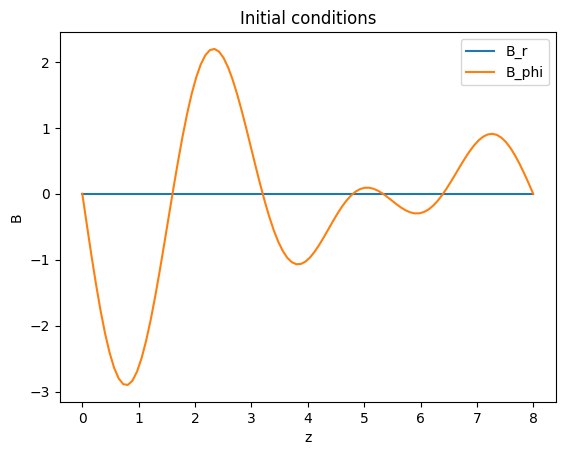

(2, 106)


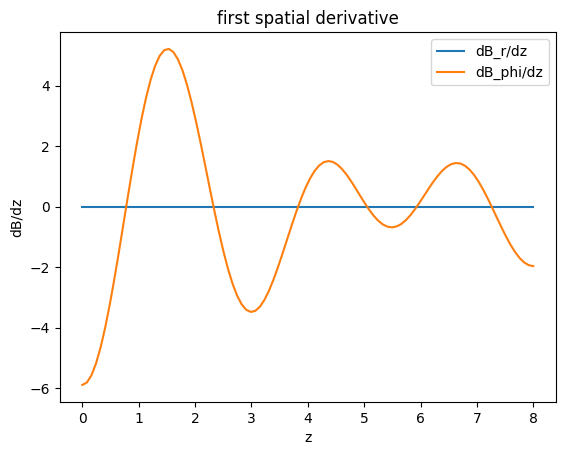

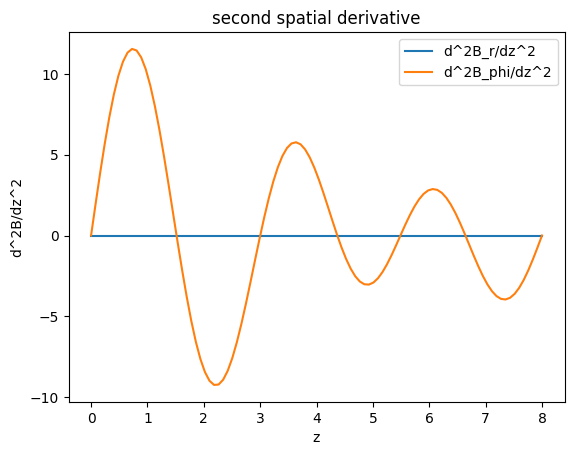

In [5]:
# plotting initial conditions
z = np.linspace(z_i, z_f, Nz)
B = np.zeros((2, Nz))
B[0, :] = B_r0(0, 0, z) # first row is B_r
B[1, :] = B_phi0(0, 0, z) # second row is B_phi

plt.plot(z, B[0, :], label = 'B_r')
plt.plot(z, B[1, :], label = 'B_phi')
plt.xlabel('z')
plt.ylabel('B')
plt.title('Initial conditions')
plt.legend()
plt.show()

if order == 'np':
    ghost_zone = 3
else:
    ghost_zone = int(order/2)

# testing the spatial_derivative function
dBdx = np.zeros(B.shape)
ddBddx = np.zeros(B.shape)
B = np.pad(B, ((0, 0), (ghost_zone, ghost_zone)), mode='constant')
print(B.shape)
for i in range(ghost_zone):
    B[:,i] = 2 * B[:,ghost_zone] - B[:,ghost_zone + ghost_zone - i] # correcting the start of the array
    B[:, -1 - i] = 2 * B[:,-ghost_zone - 1] - B[:, (- ghost_zone - 1) - ghost_zone + i] # correcting the end of the array
dx = (z_f - z_i) / (Nz - 1)  # Spatial step size
if order == 6:
    for i in range(ghost_zone, B.shape[1] - ghost_zone):
        dBdx[:, i-ghost_zone] = ((- B[:,i - 3]) + (9 * B[:,i - 2]) - (45 * B[:,i - 1]) + (45 * B[:,i + 1]) - (9 * B[:,i + 2]) + (B[:,i + 3])) / (60 * dx)
        ddBddx[:,i-ghost_zone] = ((2 * B[:,i - 3]) - (27 * B[:,i - 2]) + (270 * B[:,i - 1]) - (490 * B[:, i]) + (270 * B[:,i + 1]) - (27 * B[:,i + 2]) + (2 * B[:,i + 3])) / (180 * (dx ** 2))
else:
    dBdx = np.gradient(B, dx, axis=1)
    ddBddx = np.gradient(dBdx, dx, axis=1)

    # removing the ghost zones
    dBdx = dBdx[:,ghost_zone:-ghost_zone]
    ddBddx = ddBddx[:,ghost_zone:-ghost_zone]

plt.plot(z, dBdx[0,:], label = 'dB_r/dz')
plt.plot(z, dBdx[1,:], label = 'dB_phi/dz')
plt.xlabel('z')
plt.ylabel('dB/dz')
plt.title('first spatial derivative')
plt.legend()
plt.show()

plt.plot(z, ddBddx[0,:], label = 'd^2B_r/dz^2')
plt.plot(z, ddBddx[1,:], label = 'd^2B_phi/dz^2')
plt.xlabel('z')
plt.ylabel('d^2B/dz^2')
plt.title('second spatial derivative')
plt.legend()
plt.show()

In [6]:
# running the simulation
B_list = simulate_B_z_field(z_i, z_f, Nz, T, Nt, B_r0, B_phi0, dBdt_z, order, ghost_zone_type, iterations_to_save)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 77.10it/s]


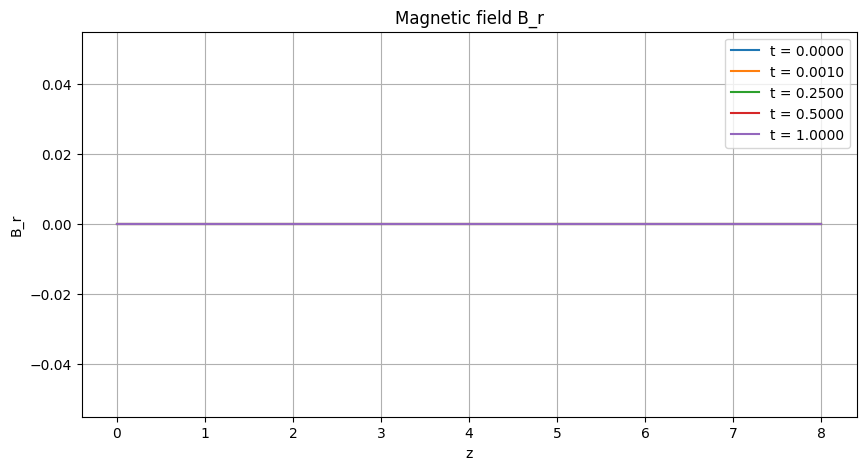

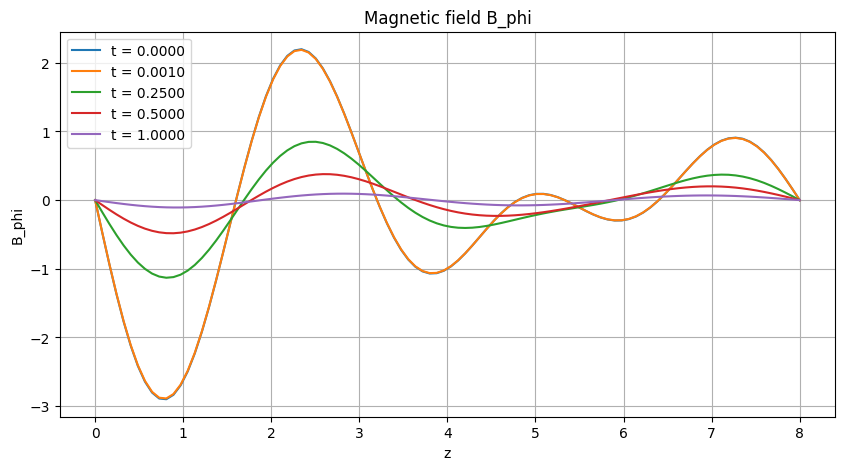

In [7]:
#plotting the results
plt.figure(figsize=(10, 5))
plt.title('Magnetic field B_r')
plt.xlabel('z')
plt.ylabel('B_r')
plt.grid(True)
for i in range(len(iterations_to_save)):
    plt.plot(np.linspace(z_i, z_f, Nz), B_list[i, 0, :], label=f't = {iterations_to_save[i] * T / Nt:.4f}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Magnetic field B_phi')
plt.xlabel('z')
plt.ylabel('B_phi')
plt.grid(True)
for i in range(len(iterations_to_save)):
    plt.plot(np.linspace(z_i, z_f, Nz), B_list[i, 1, :], label=f't = {iterations_to_save[i] * T / Nt:.4f}')
plt.legend()
plt.show()

#### $r$ implementation

In [8]:
# defining constants and parameters
eta = 1
r_i = 0.1  # start of spatial domain
r_f = 8.0 # end of spatial domain
T = 1.0  # Total simulation time
Nr = 100  # Number of spatial grid points
Nt = 1000  # Number of time steps
h = 1
delta = 0.00001 # for avoiding division by zero

r_i = r_i + delta
r_f = r_f + delta

r = np.linspace(r_i, r_f, Nr)

order = 'np'
order = 6
ghost_zone_type = 'relative anti-symmetric'

iterations_to_save = [0,1,int(Nt/4), int(Nt/2), Nt] # which time steps to save

# defining initial conditions
def B_phi0_r(r, phi, z):
    return np.sin((r_i - r)*5/8*np.pi) + np.sin((r_i - r)*6/8*np.pi) + np.sin((r_i - r)*4/8*np.pi)

def B_r0_r(r, phi, z):
    return 0

# definiing the time evolution of the magnetic field
def dBdt_r(B, r_, dBdr, ddBdr, t):
    return eta * (ddBdr + (dBdr / r_) - (B/(r_ ** 2)) + (((np.pi ** 2) / (4 * (h**2))) * B))


In [9]:
def simulate_B_r_field(r_i, r_f, Nr, T, Nt, B_r0, B_phi0, dBdt_r, order = 6, ghost_zone_type = 'relative anti-symmetric', iterations_to_save = None):
    '''    
    This function simulates the time evolution of the magnetic field B.
    
    Parameters:
    z_i: float
        The start of the spatial domain.
    z_f: float
        The end of the spatial domain.
    Nr: int
        The number of spatial grid points.
    T: float
        The total simulation time.
    Nt: int
        The number of time steps.
    B_r0: function
        The initial condition for the magnetic field B_r.
    B_phi0: function
        The initial condition for the magnetic field B_phi.
    dBdt_r: function
        The time evolution of the magnetic field B.
    order: int
        The order of the finite difference scheme. It can be 'np', 2, 4, 6, 8 or 10.
        Default is 6.
    ghost_zone_type: str
        The type of the ghost zone. It can be 'anti-symmetric', 'symmetric', 'relative anti-symmetric' or None.
        Default is 'relative anti-symmetric'.
    iterations_to_save: list
        A list of the time steps to save the solution. If None, it will save the solution at the start and end of the simulation.
        
    Returns:
    B_list: 3-D array
        A list of the magnetic field B at the required time steps from iterations_to_save.
        size: (len(iterations_to_save), 2, Nz)
    '''
    dr = (r_f - r_i) / (Nr - 1)  # Spatial step size
    dt = T / Nt  # Temporal step size
    
    # Create arrays to store the solution in time
    B_list = []

    # creating initial conditions from z, B_r0 and B_phi0
    r = np.linspace(r_i, r_f, Nr)
    r_ = np.array([r,r]) # Under the assumption that the equation is same for both B_r and B_phi
                         # We need this r_ for the equation
    
    B = np.zeros((2, Nr))
    B[0, :] = B_r0(r, 0, 0) # first row is B_r
    B[1, :] = B_phi0(r, 0, 0) # second row is B_phi
    
    if iterations_to_save is None:
        iterations_to_save = [0, Nt]

    if 0 in iterations_to_save:
        B_list.append(np.copy(B))
    
    #--------- RK4 time-stepping block ---------#
    for n in tqdm(range(1, Nt + 1)):
        # Compute spatial derivatives
        dBdr, ddBddr = spatial_derivative(B, dr, order, ghost_zone_type)


        k1 = dBdt_r(B, r_, dBdr, ddBddr, n * dt)
        k2 = dBdt_r(B + (0.5 * dt * k1), r_, dBdr, ddBddr, (n * dt) + (0.5 * dt))
        k3 = dBdt_r(B + (0.5 * dt * k2), r_, dBdr, ddBddr, (n * dt) + (0.5 * dt))
        k4 = dBdt_r(B + (dt * k3), r_, dBdr, ddBddr, (n * dt) + dt)
        
        B = B + (dt / 6.0) * (k1 + (2 * k2) + (2 * k3) + k4)
        
        # print(B)
        
        if n in iterations_to_save:
            B_list.append(np.copy(B))
    #------------------------------------------#
    
    B_list = np.array(B_list)
    
    return B_list

In [10]:
# simulating the magnetic field
B_list2 = simulate_B_r_field(r_i, r_f, Nr, T, Nt, B_r0_r, B_phi0_r, dBdt_r, order, ghost_zone_type, iterations_to_save)

100%|██████████| 1000/1000 [00:12<00:00, 77.87it/s]


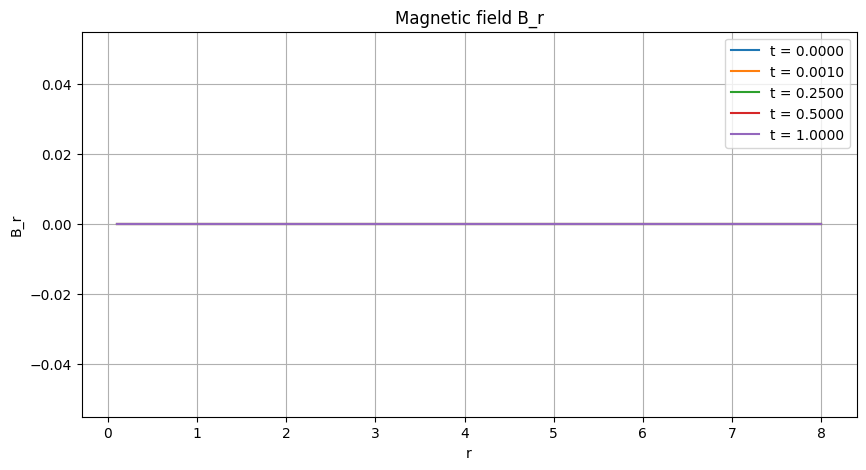

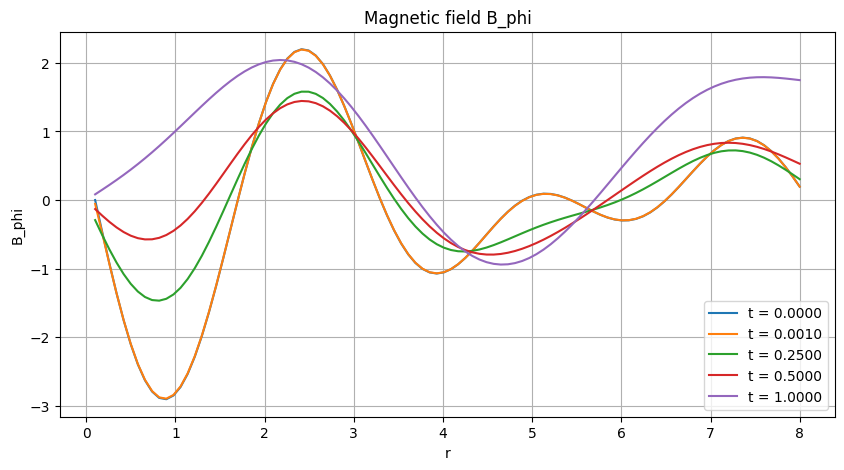

In [11]:
# plotting the results
plt.figure(figsize=(10, 5))
plt.title('Magnetic field B_r')
plt.xlabel('r')
plt.ylabel('B_r')
plt.grid(True)
for i in range(len(iterations_to_save)):
    plt.plot(np.linspace(r_i, r_f, Nr), B_list2[i, 0, :], label=f't = {iterations_to_save[i] * T / Nt:.4f}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Magnetic field B_phi')
plt.xlabel('r')
plt.ylabel('B_phi')
plt.grid(True)
for i in range(len(iterations_to_save)):
    plt.plot(np.linspace(r_i, r_f, Nr), B_list2[i, 1, :], label=f't = {iterations_to_save[i] * T / Nt:.4f}')
plt.legend()
plt.show()

[-0.05611833 -0.48479333 -0.92977242 -1.3560765  -1.74860551 -2.09604124
 -2.38905348 -2.62009784 -2.7834861  -2.87548842 -2.89440526 -2.84058924
 -2.71641017 -2.52616225 -2.27591568 -1.97331722 -1.627346   -1.24803263
 -0.8461504  -0.43288864 -0.01951849  0.3829385   0.76402849  1.11416064
  1.42487048  1.68904384  1.90109466  2.05709219  2.1548342   2.19386503
  2.17543895  2.10243107  1.9791997   1.81140572  1.60579564  1.36995615
  1.11204899  0.84053498  0.56389681  0.29036956  0.02768773 -0.21714314
 -0.43804338 -0.63001873 -0.78927819 -0.91330721 -1.00089502 -1.05211629
 -1.06826915 -1.05177277 -1.00602933 -0.93525613 -0.84429463 -0.73840389
 -0.62304611 -0.50367238 -0.38551629 -0.27340266 -0.17157823 -0.08356974
 -0.01207412  0.04111589  0.07514884  0.09011375  0.0870023   0.06763626
  0.0345636  -0.00907204 -0.0596831  -0.11340473 -0.16626971 -0.21438462
 -0.25410052 -0.28217143 -0.29589467 -0.29322772 -0.27287733 -0.23435758
 -0.17801493 -0.10501951 -0.01732319  0.08241377  0

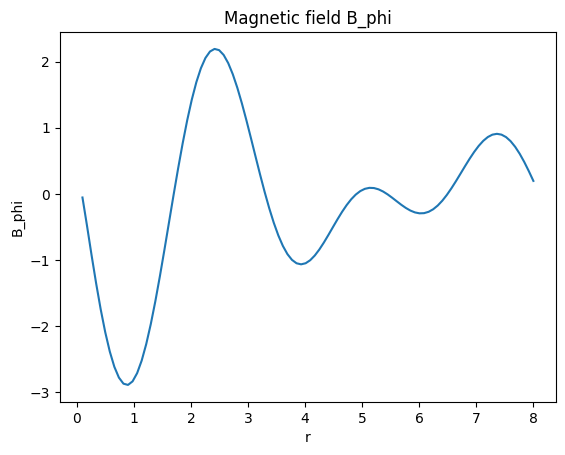

In [12]:
y = B_list2[1, 1, :]
x = np.linspace(r_i, r_f, Nr)

print(y)

plt.plot(x, y)
plt.xlabel('r')
plt.ylabel('B_phi')
plt.title('Magnetic field B_phi')
plt.show()
